In [0]:
from __future__ import print_function, division
import os
import torch
import os
import torch
from torch import nn
import pandas as pd
import torchvision
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [0]:
import tarfile
fname = 'data.tar.gz'
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [3]:
from tensorflow.python.client import device_lib; device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8597196876614895895, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14499720536423813224
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2105507316656682513
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11015956071
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8425246742526155663
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

class DenoisingDataset(Dataset):

    def __init__(self, data_dir, transform=None, train=True):
        self.train= train 
        self.x_path = os.path.join(data_dir, 'clean')
        self.y_path = os.path.join(data_dir, 'distorted')
        self.x_test_path = os.path.join(data_dir, 'test_distorted')
        self.x_files_paths = glob.glob(os.path.join(self.x_path, '*.jpg'))
        self.y_files_paths = glob.glob(os.path.join(self.y_path, '*.jpg'))
        self.x_test_files_paths = glob.glob(os.path.join(self.x_test_path, '*.jpg'))
        self.transform = transform
        self.train_data = []
        self.test_data = []
        self.labels_data = []

    def __len__(self):
        if self.train:
          return len(self.x_files_paths)
        else:
          return len(self.x_test_files_paths)

    def __getitem__(self, idx):
        if self.train: 
            x_img_name, y_img_name =  self.x_files_paths[idx], self.y_files_paths[idx]
            x_image, y_image = io.imread(x_img_name), io.imread(y_img_name)
            x = self.transform(x_image)
            y = self.transform(y_image)
            self.train_data.append(x)
            self.labels_data.append(y)
            return x,y
            
        else:
            x_test_img_name =  self.x_test_files_paths[idx]
            x_test_image = io.imread(x_test_img_name)
            x = self.transform(x_test_image)
            self.test_data.append(x)
            return x
        
    def get_train_data(self, num):
        return torch.stack(self.train_data[:num]), torch.stack(self.labels_data[:num])
    
    def get_test_data(self, num):
        return torch.stack(self.test_data[:num])


def show_img(image):
#     plt.imshow(image)
#     print(image)
    plt.imshow(image.permute(1, 2, 0).type(torch.FloatTensor)  )
    plt.pause(0.001)  # pause a bit so that plots are updated
    

def save_result(images: np.ndarray, out_path: str):
    
    assert images.shape == (400, 3, 48, 48)
    
    flat_img = images.reshape(400, -1)
    n_rows = np.prod(images.shape)
    
    y_with_id = np.concatenate([np.arange(n_rows).reshape(-1, 1), flat_img.reshape(n_rows, 1)], axis=1)
    np.savetxt(out_path, y_with_id, delimiter=",", fmt=['%d', '%.4f'], header="id,expetced", comments='')

In [0]:
train_dataset = DenoisingDataset(data_path, 
                                 transform=transforms.Compose([
                                     torchvision.transforms.ToTensor(),
                                ]))
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print(next(iter(train_loader))[0].shape)

torch.Size([32, 3, 48, 48])


tensor([[[0.4706, 0.4706, 0.4706,  ..., 0.4902, 0.4902, 0.4863],
         [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.4941, 0.4941],
         [0.5451, 0.5451, 0.5451,  ..., 0.5098, 0.5098, 0.5059],
         ...,
         [0.6863, 0.7137, 0.7333,  ..., 0.7294, 0.7294, 0.7294],
         [0.6353, 0.6627, 0.6863,  ..., 0.7098, 0.7098, 0.7098],
         [0.6000, 0.6275, 0.6510,  ..., 0.6863, 0.6863, 0.6863]],

        [[0.7333, 0.7294, 0.7294,  ..., 0.7294, 0.7294, 0.7333],
         [0.7176, 0.7176, 0.7176,  ..., 0.7333, 0.7373, 0.7373],
         [0.6980, 0.6980, 0.6941,  ..., 0.7373, 0.7373, 0.7373],
         ...,
         [0.5882, 0.6157, 0.6353,  ..., 0.6941, 0.6941, 0.6941],
         [0.5412, 0.5686, 0.5922,  ..., 0.6745, 0.6745, 0.6745],
         [0.4980, 0.5255, 0.5490,  ..., 0.6510, 0.6510, 0.6510]],

        [[0.7686, 0.7765, 0.7765,  ..., 0.9020, 0.9020, 0.9020],
         [0.7961, 0.7961, 0.7961,  ..., 0.8980, 0.8980, 0.8980],
         [0.8275, 0.8275, 0.8353,  ..., 0.8941, 0.8941, 0.

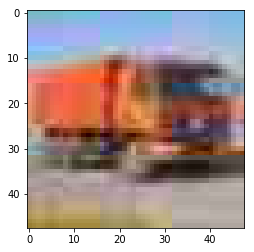

tensor([[[0.5176, 0.5412, 0.5569,  ..., 0.5725, 0.5686, 0.5647],
         [0.5333, 0.5451, 0.5490,  ..., 0.5647, 0.5569, 0.5608],
         [0.5569, 0.5451, 0.5373,  ..., 0.5569, 0.5569, 0.5608],
         ...,
         [0.6667, 0.6667, 0.8706,  ..., 0.7216, 0.7333, 0.7412],
         [0.5098, 0.5098, 0.7529,  ..., 0.6941, 0.7059, 0.7137],
         [0.5176, 0.5294, 0.5804,  ..., 0.6941, 0.6941, 0.6863]],

        [[0.7059, 0.6863, 0.6784,  ..., 0.6980, 0.7020, 0.7098],
         [0.7059, 0.6902, 0.6902,  ..., 0.7098, 0.7137, 0.7176],
         [0.7059, 0.7020, 0.7059,  ..., 0.7216, 0.7176, 0.7216],
         ...,
         [0.6157, 0.5529, 0.7137,  ..., 0.6824, 0.6941, 0.7020],
         [0.4980, 0.4314, 0.6392,  ..., 0.6588, 0.6784, 0.6863],
         [0.5333, 0.4941, 0.5176,  ..., 0.6667, 0.6706, 0.6627]],

        [[0.8627, 0.9020, 0.9333,  ..., 0.8902, 0.8824, 0.8863],
         [0.8588, 0.8980, 0.9255,  ..., 0.9137, 0.9059, 0.9098],
         [0.8588, 0.8941, 0.9137,  ..., 0.9176, 0.9216, 0.

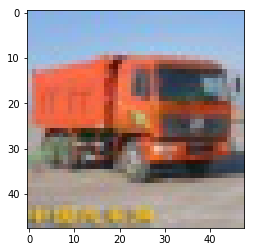

In [0]:

show_img(train_dataset.get_train_data(5)[1][3])
show_img(train_dataset.get_train_data(5)[0][3])

In [0]:
class ConvVAutoencoder(nn.Module):
    def __init__(self):
        super(ConvVAutoencoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(12 * 12 * 16, 2048)
        self.fc_bn1 = nn.BatchNorm1d(2048)
        self.fc21 = nn.Linear(2048, 2048)
        self.fc22 = nn.Linear(2048, 2048)

        # Sampling vector
        self.fc3 = nn.Linear(2048, 2048)
        self.fc_bn3 = nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, 12 * 12 * 16)
        self.fc_bn4 = nn.BatchNorm1d(12 * 12 * 16)

        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()
    def forward(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 12 * 12 * 16 )

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        mu = self.fc21(fc1)
        std = self.fc22(fc1)

        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        z = eps.mul(std).add_(mu)
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 12, 12, 16)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        out = self.conv8(conv7).view(-1, 3, 48, 48)
        return fc4, out

In [0]:
# Create the neural network
def AE(x_dict, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('autoencoder', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['noise']
        
        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        conv1 = tf.layers.conv2d(x, 32, 3, activation=tf.nn.relu)
        conv2 = tf.layers.conv2d(conv1, 32, 3, activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(conv2, 2, 2)
        conv3 = tf.layers.conv2d(pool1, 64, 3, activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(conv3, 2, 2)
        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(pool2)
        fc1=tf.reshape(fc1,shape=[-1,1,1,1600])
        conv_0T = tf.layers.Conv2DTranspose(128,(1, 1),activation=tf.nn.relu)(fc1)#1*1
        conv_1T = tf.layers.Conv2DTranspose(64,(3, 3), activation=tf.nn.relu)(conv_0T)#3*3
        conv_2T = tf.layers.Conv2DTranspose(64,(3, 3), activation=tf.nn.relu)(conv_1T)#5*5
        conv_3T = tf.layers.Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation=tf.nn.relu)(conv_2T)#10*10
        conv_4T = tf.layers.Conv2DTranspose(48,(3, 3), activation=tf.nn.relu)(conv_3T)#12*12
        conv_5T = tf.layers.Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation=tf.nn.relu)(conv_4T)#24*24
        conv_6T = tf.layers.Conv2DTranspose(16,(3, 3), activation=tf.nn.relu)(conv_5T)#26*26
        out = tf.layers.Conv2DTranspose(1,(3, 3),activation=tf.nn.sigmoid)(conv_6T)#28*28
    #print(tf.layer.all_layers)
    return out
  
def AE_loss(x_reconstructed,x_true):
  encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                       + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
  encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
  return tf.reduce_mean(encode_decode_loss)

In [0]:
class ConvAutoencoder(nn.Module):
    def __init__(self, ks):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, (ks,ks), padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, (ks,ks), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 32, (ks,ks), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, (ks,ks), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16,out_channels=32, kernel_size=(ks,ks), padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(32, 64, (ks,ks), padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(64, 32, (ks,ks), padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(32, 3, (ks,ks), padding=1),   
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [0]:

# Hyper Parameters
epochs = 10
lr = 0.005 
n_plots = 1
batch_size = 32

in_data, original_data = train_dataset.get_train_data(n_plots)
autoencoder = ConvAutoencoder(3)#AutoEncoder(latent_dim=30, image_size=48, channel_num=3)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = loss = nn.MSELoss()

autoencoder.train()
for epoch in range(epochs):
    for step, (x, y) in tqdm.tqdm(enumerate(train_loader)):
        encoded, decoded = autoencoder(x) 
#         y = y.view(-1, 3 * 48 * 48)
#         print('decoded.shape: ', decoded.shape)
#         print('y.shape: ', y.shape)

        loss = loss_func(decoded, y) 
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 100 == 0 and epoch in [0,2, 5, 7 epochs - 1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())      
            _, decoded_data = autoencoder(in_data)
#             print(in_data.shape)
#             print(decoded_data)
            show_img(in_data.squeeze(0))
            show_img(original_data.squeeze(0))
            show_img(decoded_data.data.squeeze(0))




0it [00:00, ?it/s]




NameError: ignored

(400, 3, 48, 48)
tensor([[[0.4118, 0.4118, 0.4118,  ..., 0.3608, 0.3608, 0.3608],
         [0.4078, 0.4078, 0.4078,  ..., 0.3490, 0.3490, 0.3490],
         [0.4039, 0.4039, 0.4039,  ..., 0.3490, 0.3490, 0.3490],
         ...,
         [0.4588, 0.4275, 0.4235,  ..., 0.3686, 0.3882, 0.4000],
         [0.3882, 0.3686, 0.3922,  ..., 0.2980, 0.3255, 0.3451],
         [0.3255, 0.3137, 0.3608,  ..., 0.2549, 0.2863, 0.3059]],

        [[0.3647, 0.3647, 0.3647,  ..., 0.3686, 0.3686, 0.3686],
         [0.3647, 0.3647, 0.3647,  ..., 0.3569, 0.3569, 0.3569],
         [0.3608, 0.3608, 0.3608,  ..., 0.3569, 0.3569, 0.3569],
         ...,
         [0.4235, 0.3922, 0.3882,  ..., 0.3686, 0.3882, 0.4000],
         [0.3529, 0.3333, 0.3569,  ..., 0.2980, 0.3255, 0.3451],
         [0.2902, 0.2784, 0.3255,  ..., 0.2549, 0.2863, 0.3059]],

        [[0.4039, 0.4039, 0.4039,  ..., 0.3255, 0.3255, 0.3255],
         [0.3961, 0.3961, 0.3961,  ..., 0.3137, 0.3137, 0.3137],
         [0.3922, 0.3922, 0.3922,  ..., 0

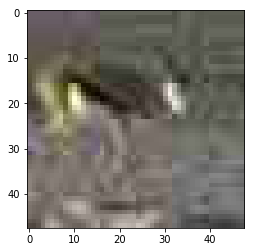

tensor([[[0.3937, 0.3758, 0.3755,  ..., 0.3209, 0.3294, 0.3178],
         [0.3609, 0.3652, 0.3767,  ..., 0.3340, 0.3299, 0.3281],
         [0.3612, 0.3639, 0.3701,  ..., 0.3630, 0.3594, 0.3593],
         ...,
         [0.3855, 0.3929, 0.4379,  ..., 0.3362, 0.3686, 0.3829],
         [0.3175, 0.3473, 0.4088,  ..., 0.2283, 0.2722, 0.3120],
         [0.3666, 0.3729, 0.4399,  ..., 0.2706, 0.2664, 0.2987]],

        [[0.3903, 0.3900, 0.3948,  ..., 0.3388, 0.3362, 0.3365],
         [0.3534, 0.3669, 0.3857,  ..., 0.3636, 0.3557, 0.3450],
         [0.3551, 0.3681, 0.3802,  ..., 0.3967, 0.3852, 0.3763],
         ...,
         [0.3532, 0.3711, 0.4170,  ..., 0.3466, 0.3631, 0.3728],
         [0.2955, 0.3189, 0.3821,  ..., 0.2454, 0.2862, 0.3104],
         [0.3539, 0.3545, 0.4287,  ..., 0.2738, 0.2872, 0.3069]],

        [[0.3777, 0.3954, 0.4021,  ..., 0.3028, 0.3012, 0.3196],
         [0.3684, 0.3781, 0.4009,  ..., 0.3173, 0.3076, 0.3008],
         [0.3551, 0.3689, 0.3907,  ..., 0.3620, 0.3429, 0.

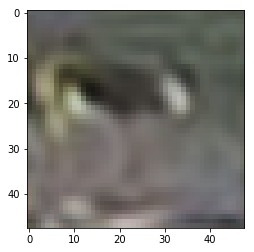

In [0]:
test_dataset = DenoisingDataset(data_path, 
                                train=False,
                                transform=transforms.Compose([
                                   torchvision.transforms.ToTensor()
#                                    torchvision.transforms.Lambda(lambda x: x.flatten())
                                ]))

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
decoded_samples = []
autoencoder.eval()
for step, x in enumerate(test_loader):
    
    en_x, de_x = autoencoder(x)
    decoded_samples.append(de_x.detach().numpy())
    # encode the points into the latent space and save for later estimation
    
sampled_z = np.concatenate(decoded_samples, axis=0)
print(sampled_z.shape)
save_result(sampled_z, 'solution.csv')
show_img(x[0].squeeze(0))#.view(3,48, 48))
# show_img(original_data.squeeze(0))#.view(3,48, 48))
show_img(de_x[0].data.squeeze(0))


In [0]:
torch.save(autoencoder.state_dict(), 'tmp_model.pt')

In [0]:
autoencoder.load_state_dict(torch.load('tmp_model.pt'))
